In [150]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Vectorizing texts

In [2]:
#getting the vocabulary
f = open('voc_complete', 'rb')
voc_complete = pickle.load(f)
f.close()

In [78]:
#converting list members from tuples to strings
#has to be this way so tokenizer can recognize them, because it returns strings
voc_complete2 = []
for i in voc_complete:
    voc_complete2.append(str(i))

In [105]:
#getting the data
dataTrain = pd.read_pickle('trainReduced')
dataTest = pd.read_pickle('testReduced')

In [12]:
dataTrain.head()

,qid,question_text,target
1230084,f10da363cb457e4c60c3,Is there any way I can play videos from Google...,0
1236209,f242c600958872ff5b2f,How do I make it say a certain date on ’their ...,0
1084571,d48b89e2d8713c72c1cb,Which is the best company for regular rolled o...,0
598192,752aba52e05a2c7e7f46,How can a Nepali worker from Malaysia go to Si...,0
864468,a9623a55b06591fb6568,What does it mean when a girl challenges you?,0


In [106]:
dataTest.head()

,qid,question_text,target
331389,40f4ce4c3b38dfeffc4d,How did you learn Mandarin fluently?,0
548597,6b78a71d6d629c5959ef,How can I let my family know that I don't want...,0
527242,673a6cfad3e38f4d9406,New car seat = New Back Pain. Why?,0
106927,14f0b38fd6ae034c276f,Can you play guitar while singing in a global ...,0
101469,13dfa1d5693bc4e9bf0f,I live in Brazil. Is it possible for me to inv...,0


In [13]:
#using countvectorizer for start
from sklearn.feature_extraction.text import CountVectorizer

In [94]:
#defining tokenizing function
#returns stemmed and pos tagged tokens
#they are strings, identical as in vocabulary, so countvectorizer recognizes them
def tok(x):
    import nltk
    from nltk.tokenize import RegexpTokenizer
    regexptok = RegexpTokenizer('\w+')
    tokenized = regexptok.tokenize(x)
    possed = nltk.pos_tag(tokenized)
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    stemmed = []
    for i in possed:
        stemmed.append(str((ps.stem(i[0]), i[1])))
    return(stemmed)

In [96]:
#using defined tokenizer, defined vocabulary and ngram range returns single words, bigrams and trigrams
cv = CountVectorizer(tokenizer = tok, vocabulary=voc_complete2, ngram_range=(1,3))

In [97]:
X_train = cv.fit_transform(dataTrain['question_text'].values)

In [98]:
X_train

<200000x19311 sparse matrix of type '<class 'numpy.int64'>'
	with 1066284 stored elements in Compressed Sparse Row format>

In [114]:
#pickling
f1 = open('X_train', 'wb')
pickle.dump(X_train, f1)
f1.close()

In [107]:
X_test = cv.transform(dataTest['question_text'].values)

In [108]:
X_test

<20000x19311 sparse matrix of type '<class 'numpy.int64'>'
	with 105474 stored elements in Compressed Sparse Row format>

In [115]:
#pickling
f2 = open('X_test', 'wb')
pickle.dump(X_test, f2)
f2.close()

# Predictive models

In [110]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

In [272]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [118]:
y_train = dataTrain['target'].values
y_test = dataTest['target'].values

In [365]:
mnb = MultinomialNB()
cnb = ComplementNB()

### Multinomial NB on all features

In [366]:
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [367]:
mnb.score(X_test, y_test)

0.9331

In [368]:
scores1 = precision_recall_fscore_support(y_test, mnb.predict(X_test))

In [369]:
scores_table1 = pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table1.iloc[i,:] = [x[i] for x in scores1]
scores_table1

,precision,recall,f1,support
0,0.970380,0.957725,0.964011,18711.0
1,0.484018,0.575640,0.525868,1289.0


Text(33.0, 0.5, 'true')

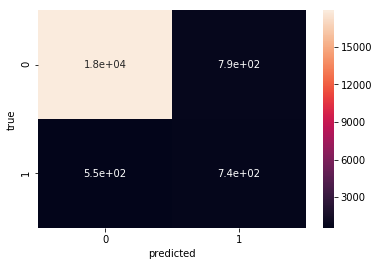

In [370]:
sns.heatmap(confusion_matrix(y_test, mnb.predict(X_test)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

### ComplementNB on all features

In [371]:
cnb.fit(X_train, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [372]:
cnb.score(X_test, y_test)

0.8266

In [373]:
scores2 = precision_recall_fscore_support(y_test, cnb.predict(X_test))

In [374]:
scores_table2 = pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table2.iloc[i,:] = [x[i] for x in scores2]
scores_table2

,precision,recall,f1,support
0,0.987339,0.825236,0.899039,18711.0
1,0.250172,0.846393,0.386195,1289.0


Text(33.0, 0.5, 'true')

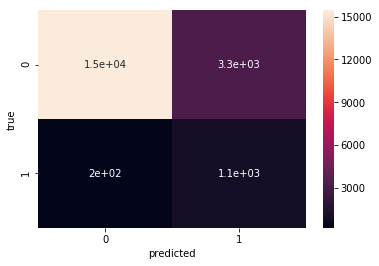

In [375]:
sns.heatmap(confusion_matrix(y_test, cnb.predict(X_test)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

## Using tfidf

In [376]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()

In [377]:
X_traintf = tf.fit_transform(X_train)
X_testtf = tf.transform(X_test)

#### Multinomial NB

In [378]:
mnb.fit(X_traintf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [379]:
mnb.score(X_testtf, y_test)

0.93905

In [380]:
scores3 = precision_recall_fscore_support(y_test, mnb.predict(X_testtf))

In [381]:
scores_table3= pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table3.iloc[i,:] = [x[i] for x in scores3]
scores_table3

,precision,recall,f1,support
0,0.941004,0.997381,0.968373,18711.0
1,0.708333,0.092320,0.163349,1289.0


Text(33.0, 0.5, 'true')

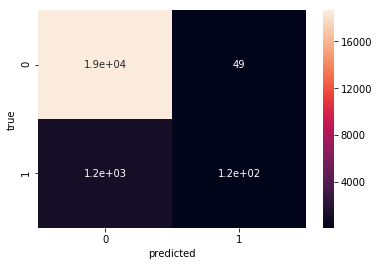

In [382]:
sns.heatmap(confusion_matrix(y_test, mnb.predict(X_testtf)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

#### Complement NB

In [383]:
cnb.fit(X_traintf, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [384]:
cnb.score(X_traintf, y_train)

0.85762

In [403]:
scores4 = precision_recall_fscore_support(y_test, cnb.predict(X_testtf))

In [404]:
scores_table4= pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table4.iloc[i,:] = [x[i] for x in scores4]
scores_table4

,precision,recall,f1,support
0,0.984456,0.856341,0.915940,18711.0
1,0.278195,0.803724,0.413325,1289.0


Text(33.0, 0.5, 'true')

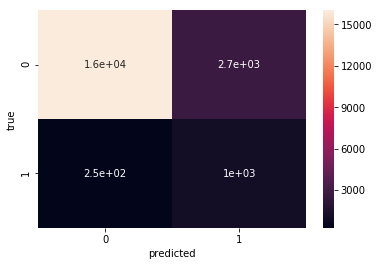

In [387]:
sns.heatmap(confusion_matrix(y_test, cnb.predict(X_testtf)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

# Grid search for best model

Using F2 score (variation f fbeta where beta is 2: favours recal more than precision). We favour recall more because we  want to avoid true insincere questions classified as sincere questions. However, we also want to avoid too much sincere questions to be classified as sincere.
## Multinomial NB
### No tfidf

In [389]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

In [535]:
#multinomial NB hyperparameters
parameters1 = {'alpha' :[0,0.1,0.3,0.5,0.7,1,1.3,1.5,1.7,2,3,5], 'fit_prior' : [True, False]}
gs1 = GridSearchCV(estimator=MultinomialNB(), param_grid=parameters1, scoring=make_scorer(fbeta_score, beta = 2), 
                   cv=5, n_jobs=-1)
gs1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1, 1.3, 1.5, 1.7, 2, 3, 5], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [536]:
gs1.score(X_test, y_test)

0.5661893629456458

In [537]:
gs1.best_estimator_

MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)

In [507]:
#evaluating this estimator
mnb1 = MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)

In [508]:
mnb1.fit(X_train, y_train)

MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)

In [509]:
mnb1.score(X_test,y_test)

0.92865

In [510]:
scores5 = precision_recall_fscore_support(y_test, mnb1.predict(X_test))

In [511]:
scores_table5= pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table5.iloc[i,:] = [x[i] for x in scores5]
scores_table5

,precision,recall,f1,support
0,0.971931,0.951205,0.961456,18711.0
1,0.459123,0.601241,0.520658,1289.0


Text(33.0, 0.5, 'true')

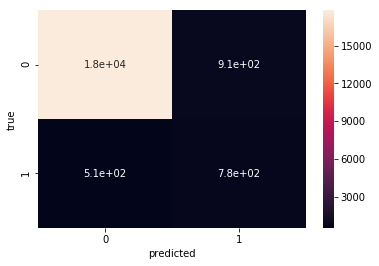

In [512]:
sns.heatmap(confusion_matrix(y_test, mnb1.predict(X_test)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

### TfIdf

In [538]:
gs1.fit(X_traintf, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1, 1.3, 1.5, 1.7, 2, 3, 5], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [539]:
gs1.score(X_testtf, y_test)

0.5827330394581228

In [540]:
gs1.best_estimator_

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

In [529]:
mnb2 = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)
mnb2.fit(X_traintf, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

In [530]:
mnb2.score(X_testtf, y_test)

0.8367

In [531]:
scores6 = precision_recall_fscore_support(y_test, mnb2.predict(X_testtf))

In [532]:
scores_table6= pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table6.iloc[i,:] = [x[i] for x in scores6]
scores_table6

,precision,recall,f1,support
0,0.98707,0.836406,0.905514,18711.0
1,0.26152,0.840962,0.398969,1289.0


Text(33.0, 0.5, 'true')

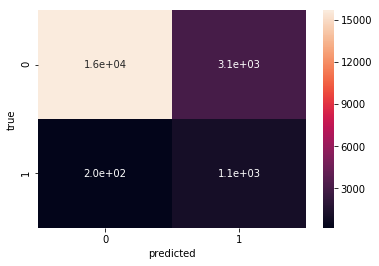

In [534]:
sns.heatmap(confusion_matrix(y_test, mnb2.predict(X_testtf)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

## Complement NB
### NO TfIdf

In [542]:
#Complement NB hyperparameters
parameters2 = {'alpha':[0,0.1,0.3,0.5,0.7,1,1.5,2,3,5], 'fit_prior':[True,False], 'norm':[False,True]}
gs2 = GridSearchCV(estimator=ComplementNB(), param_grid=parameters2, scoring=make_scorer(fbeta_score, beta = 2),
                  cv=5, n_jobs=-1)

In [543]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5], 'fit_prior': [True, False], 'norm': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [546]:
gs2.score(X_test, y_test)

0.5771448339483395

In [547]:
gs2.best_estimator_

ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=True)

In [548]:
cnb1 = ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=True)

In [549]:
cnb1.fit(X_train, y_train)

ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=True)

In [550]:
cnb.score(X_test, y_test)

0.8655

In [551]:
scores7 = precision_recall_fscore_support(y_test, cnb1.predict(X_test))

In [552]:
scores_table7 = pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table7.iloc[i,:] = [x[i] for x in scores7]
scores_table7

,precision,recall,f1,support
0,0.982529,0.865587,0.920358,18711.0
1,0.284699,0.776571,0.416649,1289.0


Text(33.0, 0.5, 'true')

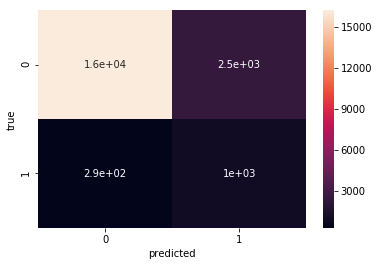

In [553]:
sns.heatmap(confusion_matrix(y_test, cnb1.predict(X_test)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

### TfIdf

In [554]:
gs2.fit(X_traintf, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5], 'fit_prior': [True, False], 'norm': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [555]:
gs2.score(X_testtf, y_test)

0.5827330394581228

In [556]:
gs2.best_estimator_

ComplementNB(alpha=0.5, class_prior=None, fit_prior=True, norm=False)

In [557]:
cnb2 = ComplementNB(alpha=0.5, class_prior=None, fit_prior=True, norm=False)

In [558]:
cnb2.fit(X_traintf, y_train)

ComplementNB(alpha=0.5, class_prior=None, fit_prior=True, norm=False)

In [559]:
cnb2.score(X_testtf, y_test)

0.8367

In [560]:
scores8 = precision_recall_fscore_support(y_test, cnb2.predict(X_testtf))

In [561]:
scores_table8 = pd.DataFrame(np.empty((len(scores1[0]),4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores1[0])):
    scores_table8.iloc[i,:] = [x[i] for x in scores8]
scores_table8

,precision,recall,f1,support
0,0.98707,0.836406,0.905514,18711.0
1,0.26152,0.840962,0.398969,1289.0


Text(33.0, 0.5, 'true')

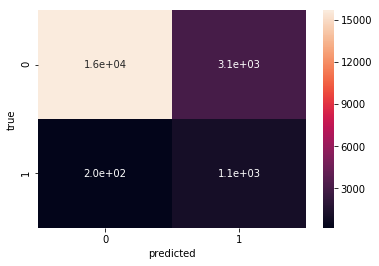

In [562]:
sns.heatmap(confusion_matrix(y_test, cnb2.predict(X_testtf)), annot=True)
plt.xlabel('predicted')
plt.ylabel('true')

# Chosing the best  model

##### Best balanced, highest accuracy:
- Multinomial NB, no TfIdf
##### Best in avoiding misclassification of insincere questions:
- Complement NB or Multinomial NB, TfIdf. However, we pay the price with greater misclassification of sincere questions as insincere
- Complement NB with no TfIdf is a bit more balanced version of this model.